## 절대로 전체 실행 누르지 말것

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
import scipy.io as sio
from scipy.signal import freqz
from scipy.signal import butter, lfilter
#np.set_printoptions(threshold=np.inf)
import csv

In [3]:
slp03_matfile = "slp03m"
slp03_annotationfile = "slp03_annotation"

In [4]:
#variables for sensor data
ecg = []
bp = []
eeg = []
resp = []

#variables for annotation data
time = []
sample_num = []
sleep_stage = []

In [5]:
def read_mat(filename, num_data,ecg, bp, eeg, resp):
    mat_contents = sio.loadmat('data/'+filename+'.mat')
    val = mat_contents['val']
    ecg.append(val[0])
    bp.append(val[1])
    eeg.append(val[2])
    resp.append(val[3])
    for i in range(1,num_data):
        mat_contents = sio.loadmat('data/'+filename+' (%d).mat'% i)
        val = mat_contents['val']
        ecg.append(val[0])
        bp.append(val[1])
        eeg.append(val[2])
        resp.append(val[3])

In [6]:
def read_anno(filename, time, sample_num, sleep_stage):
    filename = "data/"+filename+".csv"
    with open(filename,newline='',encoding = 'utf-8') as csvfile:
        reader = csv.reader (csvfile)
        next(reader, None)
        for row in reader:
            time.append(row[0])
            sample_num.append(int(row[1]))
            sleep_stage.append(row[6])

In [7]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [8]:
read_mat(slp03_matfile, 6, ecg, bp, eeg, resp)

In [9]:
ecg = list(itertools.chain(*ecg))
bp = list(itertools.chain(*bp))
eeg = list(itertools.chain(*eeg))
resp = list(itertools.chain(*resp))

In [10]:
#30초마다 한번씩 샘플링됨
read_anno(slp03_annotationfile, time, sample_num, sleep_stage)

In [11]:
print(sleep_stage)
print(len(sleep_stage))

['2', '2', '2', '2', 'W', '1', 'W', '1', '1', '1', '1', 'W', '1', '1', 'W', 'W', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', 'R', 'W', '1', '1', 'R', 'R', 'R', 'R', 'R', '1', 'R', 'R', 'R', 'R', '1', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '1', '1', 'R', '1', 'R', 'R', '1', 'R', 'R', 'R', '1', '1', '1', 'R', 'R', 'R', '1', 'R', '1', 'R', '1', '1', 'R', '1', 'R', 'R', 'R', 'R', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1', '2', '2', '2', '2', '2', '1', '2', '2', '1', '2', '2', '1', '1', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '1', '1', '1', '1', '1', '1',

In [12]:
print(sample_num[-1])
print(sample_num[0]-7500)
sample_num[-1]-(sample_num[0]-7500)

5392500
60000


5332500

In [13]:
def convert_to_quarter_size(ecg, bp, eeg,resp, sampling_num):
    temp_ecg = [ecg[4*i+sampling_num] for i in range(0,int(len(ecg)/4))]
    temp_bp = [bp[4*i+sampling_num] for i in range(0,int(len(bp)/4))]
    temp_eeg = [eeg[4*i+sampling_num] for i in range(0,int(len(eeg)/4))]
    temp_resp = [resp[4*i+sampling_num] for i in range(0,int(len(resp)/4))]
    return temp_ecg, temp_bp, temp_eeg, temp_resp

In [14]:
def sync_sample(sample_num, ecg, bp, eeg, resp):
    temp_ecg = ecg[sample_num[0]-7500:sample_num[-1]]
    temp_bp = bp[sample_num[0]-7500:sample_num[-1]]
    temp_eeg = eeg[sample_num[0]-7500:sample_num[-1]]
    temp_resp = resp[sample_num[0]-7500:sample_num[-1]]
    return temp_ecg, temp_bp, temp_eeg, temp_resp

In [15]:
ecg, bp, eeg, resp = sync_sample(sample_num, ecg, bp, eeg, resp)
q0_ecg,q0_bp,q0_eeg,q0_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 0)
q1_ecg,q1_bp,q1_eeg,q1_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 1)
q2_ecg,q2_bp,q2_eeg,q2_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 2)
q3_ecg,q3_bp,q3_eeg,q3_resp = convert_to_quarter_size(ecg, bp, eeg, resp, 3)

In [16]:
print(len(ecg))
print(len(q0_ecg))
print(len(q1_bp))
print(len(q2_eeg))
print(len(q3_resp))

5332500
1333125
1333125
1333125
1333125


In [17]:
def pool_data(q0,q1,q2,q3):
    return q0+q1+q2+q3

In [18]:
def zip_sensor(ecg, bp, eeg, resp):
    return [list(i) for i in zip(ecg, bp, eeg, resp)]

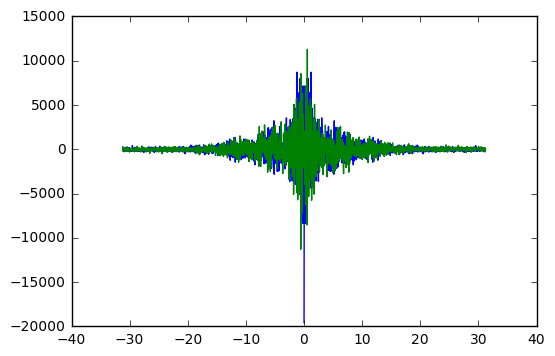

2


In [22]:
temp = np.array(q0_eeg[:1875])
sp = np.fft.fft(temp)
freq = np.fft.fftfreq(temp.shape[-1], 1/62.5)
plt.plot(freq,sp.real, freq, sp.imag)
plt.show()
print(sleep_stage[0])

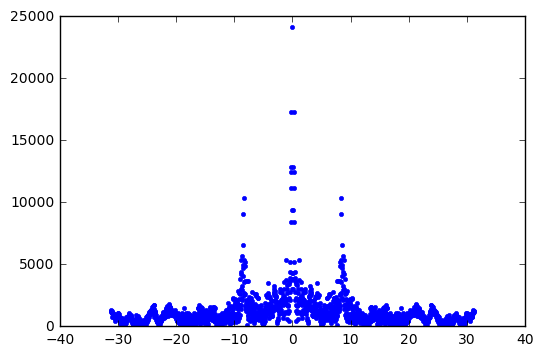

In [78]:
amp = np.abs(sp)
plt.plot(freq, amp, 'b.')
plt.show()

In [19]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

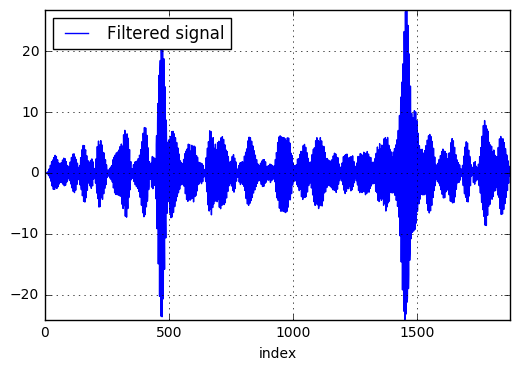

In [28]:
x = temp
fs = 62.5
lowcut = 12
highcut = 14

order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order)
plt.plot(y, label='Filtered signal')
plt.xlabel('index')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

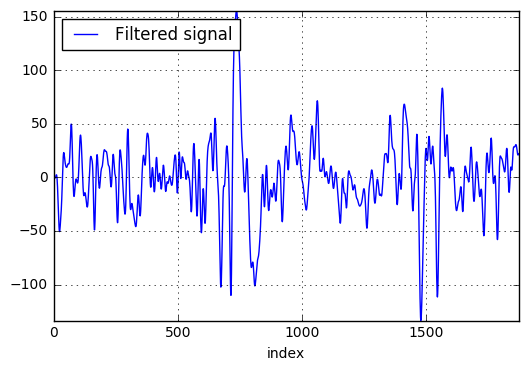

In [32]:
fs = 62.5
lowcut = 0.1
highcut = 3.99

order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order)
plt.plot(y, label='Filtered signal')
plt.xlabel('index')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

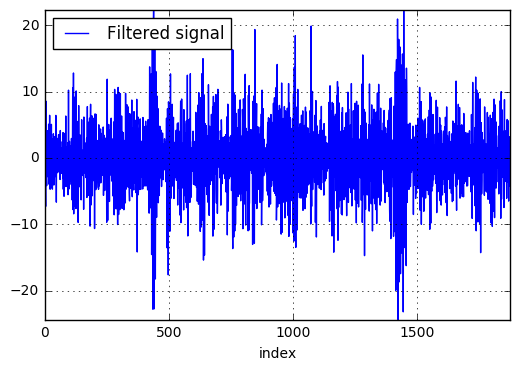

In [33]:
fs = 62.5
lowcut = 13
highcut = 30

order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order)
plt.plot(y, label='Filtered signal')
plt.xlabel('index')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

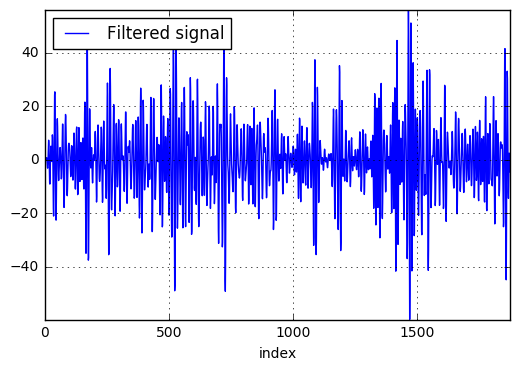

In [34]:
fs = 62.5
lowcut = 4
highcut = 7.99

order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order)
plt.plot(y, label='Filtered signal')
plt.xlabel('index')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

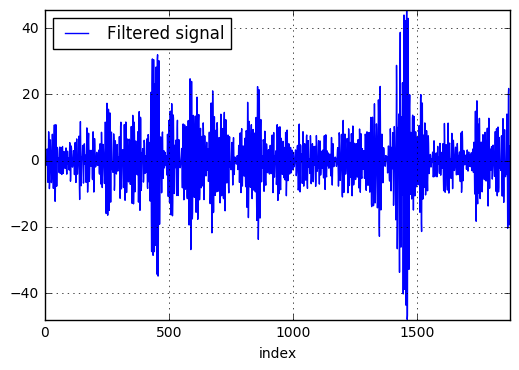

In [35]:
fs = 62.5
lowcut = 8
highcut = 12.99

order = 5
b, a = butter_bandpass(lowcut, highcut, fs, order=order)
w, h = freqz(b, a, worN=2000)
y = butter_bandpass_filter(x, lowcut, highcut, fs, order)
plt.plot(y, label='Filtered signal')
plt.xlabel('index')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

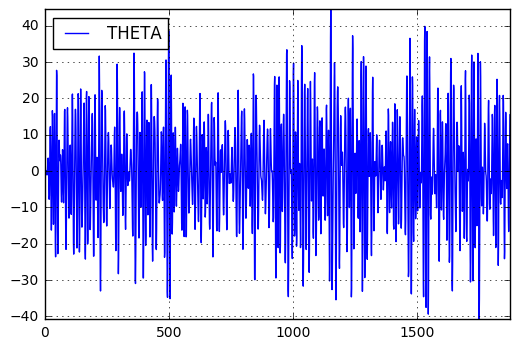

In [38]:
y = butter_bandpass_filter(temp, 4, 7.99, fs, 6)
plt.plot(y, label='THETA')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

In [43]:
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a
def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [47]:
for i in range(0,len(sleep_stage)):
    temp = np.array(q0_eeg[1875*i:1875*(i+1)])
    
    plt.figure(figsize = (10,15))
    plt.suptitle('sleep stage : '+sleep_stage[i], fontsize=30, fontweight='bold')
    
    plt.subplot(711)
    plt.plot(temp,'g-')
    plt.axis([0, 1900, -500, 500])
    plt.xlabel('EEG_index(*4)')
    plt.ylabel('EEG_code')
    
    plt.subplot(712)
    sp = np.fft.fft(temp)
    freq = np.fft.fftfreq(temp.shape[-1], 1/62.5)
    amp = np.abs(sp)
    plt.plot(freq, amp,'g-')
    plt.axis([-35, 35, 0, 10000])
    plt.xlabel('freq')
    plt.ylabel('spectrum')
       
    plt.subplot(713)
    fs = 62.5
    y = butter_bandpass_filter(temp, 8, 12.99, fs, 6)
    plt.plot(y, label='ALPHA(8~12.99 Hz)')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    
    plt.subplot(714)
    y = butter_bandpass_filter(temp, 13, 30, fs, 6)
    plt.plot(y, label='BETA(13~30 Hz)')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    
    plt.subplot(715)
    y = butter_bandpass_filter(temp, 4, 7.99, fs, 6)
    plt.plot(y, label='THETA(4~7.99 Hz)')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    
    plt.subplot(716)
    y = butter_lowpass_filter(temp, 3.99, fs, 6)
    plt.plot(y, label='DELTA(~3.99 Hz)')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    
    plt.subplot(717)
    y = butter_bandpass_filter(temp, 12, 14, fs, 6)
    plt.plot(y, label='Sleep spindle(12~14 Hz)')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    
    plt.savefig('fft/sleep stage_'+sleep_stage[i]+'_'+str(i)+'.png', dpi = 300)
    plt.close()